In [44]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from numba import jit
import itertools

* $Ackley(x) = -a * exp(-b \sqrt{\frac{1}{d}\sum_{i=1}^{d}x_i^2}) - exp(\frac{1}{d}\sum_{i=1}^{d}cos(cx_i)) + a + e$
* $Dixon\_Price(x) = (x_i - 1)^2 + \sum_{i=2}^{d}i(2x_i^2 - x_{i-1})^2$
* $Rosenbrock(x) = \sum_{i=1}^{d-1} \left[ 100(x_{i+1}-x_i^2)^2 + (x_i - 1)^2 \right]$
* $Griewank(x) = \sum_{i=i}^{d}\frac{x_i^2}{4000} - \Pi_{i=1}^{d}cos(\frac{x_i}{\sqrt{i}}) + 1$
* $Schwefel(x) = 418.9829d - \sum_{i=1}^{d}x_i * sin(\sqrt{|x_i|})$

In [65]:
@jit(nopython=True)
def Ackley(X):
    n = len(X)
    a = 20
    b = 0.2
    c = 2 * np.pi

    return -a * np.exp(- b * np.sqrt((X @ X)/n)) - np.exp((np.cos(c * X)).sum()/n) + a + np.e

@jit(nopython=True)
def Dixon_Price(X):
    n = len(X)
    return (X[0] - 1)**2 + (np.arange(2, n+1) * (2*X[1:]**2 - X[:-1])**2).sum()

@jit(nopython=True)
def Rosenbrock(X):
    return (100*(X[1:]-X[:-1]**2)**2 + (X[:-1]**2)).sum()


@jit(nopython=True)
def Griewank(X):
    n = len(X)
    return ((X**2).sum())/4000 - np.cos(X/np.sqrt(np.arange(1, n+1))).prod() + 1

@jit(nopython=True)
def Schwefel(X):
    n = len(X)
    s = 0
    for xi in X:
        s += xi * np.sin(np.sqrt(np.abs(xi)))
    return 418.9829*n - s


In [51]:
def random_individual(n, min_bound=0, max_bound=1):
    values = [np.random.rand() * (max_bound - min_bound) + min_bound for _ in range(n)]

    return values

def random_sigma_chromosome(n):
    return [np.random.randn() for _ in range(n)]

def random_population(N, n, min_bound=0, max_bound=1):
    values = np.array([random_individual(n, min_bound, max_bound) for _ in range(N)])
    sigmas = np.array([random_sigma_chromosome(n) for _ in range(N)])

    return values, sigmas

@jit(nopython=True)
def population_evaluation(P, F):
    scores = np.zeros(len(P))
    for i in range(len(scores)):
        scores[i] = F(P[i])
    return scores

def parent_selection(P, scores, n_offspring):
    population_size = len(P)

    fitness_values = scores.max() - scores
    if fitness_values.sum() > 0:
        fitness_values = fitness_values / fitness_values.sum()
    else:
        fitness_values = np.ones(population_size) / population_size

    parent_indices = np.random.choice(population_size, n_offspring, True, fitness_values).astype(np.int64)

    return parent_indices

def is_in_bound(x, min_bound, max_bound):
    for xi in x:
        if xi > max_bound or xi < min_bound:
            return False

    return True

def mutation(P, S, tau, tau0, min_bound, max_bound):
    N = len(P)
    n = len(P[0])

    def mutate_ind(i):
        epsilon0 = np.random.randn() * tau0
        epsilons = np.random.randn(n) * tau

        new_S = S[i] * np.exp(epsilons + epsilon0)

        epsilons = np.random.randn(n) * new_S

        new_P = P[i] + epsilons

        return new_P, new_S

    for i in range(N):
        Pi, Si = mutate_ind(i)

        while not is_in_bound(Pi, min_bound, max_bound):
            Pi, Si = mutate_ind(i)

        P[i], S[i] = Pi, Si
        

def ES(F, c_len, population_size, offspring_size, tau, tau0, iterations, min_bound=-5, max_bound=5, plus=True):
    P, S = random_population(population_size, c_len, min_bound, max_bound)
    scores = population_evaluation(P, F)

    history = []
    history.append(P)
    
    history_scores = []
    history_scores.append(scores)
    
    for _ in tqdm(range(iterations)):
        c_ind = parent_selection(P, scores, offspring_size)
        P_c = P[c_ind]
        S_c = S[c_ind]

        # print(P_c)
        mutation(P_c, S_c, tau, tau0, min_bound, max_bound)

        scores_c = population_evaluation(P_c, F)

        # Replacement

        if plus:
            P_all = np.vstack((P, P_c))
            S_all = np.vstack((S, S_c))
            scores_all = np.hstack((scores, scores_c))
        else:
            P_all = P_c
            S_all = S_c
            scores_all = scores_c

       

        sorted_scores_ind = np.argsort(scores_all)

        P = P_all[sorted_scores_ind[:population_size]]
        S = S_all[sorted_scores_ind[:population_size]]
        scores = scores_all[sorted_scores_ind[:population_size]]
        # print(scores.min(), scores.mean(), scores.max())
        # stats.append((scores.min(), scores.mean(), scores.max()))
        history.append(P)
        history_scores.append(scores)

    return history, history_scores



In [98]:
def plot_min_max_mean(populations_objective_values):
    line_width = 1.5
    ea_means = np.mean(populations_objective_values, axis=1)
    ea_maxs = np.max(populations_objective_values, axis=1)
    ea_mins = np.min(populations_objective_values, axis=1)

    plt.figure(figsize=[12, 7])

    plt.axis(True)
    plt.grid(True)

    plt.plot(ea_means, linewidth=1.5, label="mean")
    plt.plot(ea_mins, linewidth=1.5, label="min")
    plt.plot(ea_maxs, linewidth=1.5, label="max")
    plt.legend()
    plt.show()

In [88]:
def best_individual(populations, scores):
    best_pop = 0
    best_ind = 0
    for i in range(len(populations)):
        for j in range(len(populations[i])):
            if scores[best_pop][best_ind] > scores[i][j]:
                best_pop, best_ind = i, j

    return populations[i][j], scores[i][j]

100%|██████████| 1000/1000 [00:33<00:00, 29.46it/s]


(array([-5.95355372e+00,  2.29751052e+01,  5.99419221e+00,  8.98609029e+00,
        7.97453177e+00,  1.99671299e+00,  6.99305937e+00, -2.99545508e+00,
        1.00408552e+00,  1.99619186e+00,  1.19920484e+01, -1.99443767e+00,
       -7.99060550e+00, -1.99638435e+00,  1.99725466e+00,  4.01809932e+00,
       -6.99058605e+00, -2.00214521e+00,  2.00573280e+00, -1.00256170e+00,
        1.99762748e+00,  5.72613521e-03, -1.59794310e+01,  6.99162373e+00,
        6.98941059e+00,  3.80690410e+00, -3.99347039e+00, -3.99545682e+00,
       -9.98848579e-01,  4.99243270e+00, -4.99559741e+00,  9.98582223e+00,
        2.00118491e+00, -3.99607513e+00, -1.99673824e+00, -2.99985715e+00,
        6.99099983e+00,  1.29852652e+01, -6.98820568e+00, -5.99486362e+00,
       -9.98360792e-01, -3.12488026e-04,  9.98406689e-01, -2.99539167e+00,
        1.39820284e+01,  4.99180108e+00, -6.99363849e+00,  1.07883095e+00,
       -6.98948930e+00, -1.39835239e+01]), 15.21263480899363)


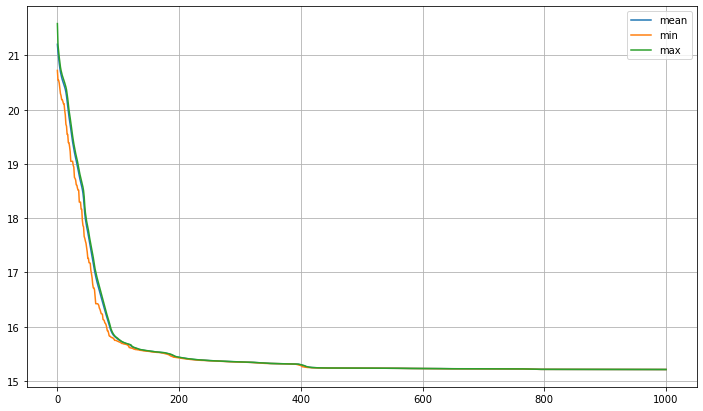

In [91]:
l = 50
t = 1/np.sqrt(2*l)
t0 = 1/np.sqrt(2*np.sqrt(l))

populations, scores = ES(F=Ackley, c_len=l, population_size=1000, offspring_size=1000, tau=t, tau0=t0, iterations=1000, min_bound=-32, max_bound=32)


print(best_individual(populations, scores))
plot_min_max_mean(scores)

100%|██████████| 2000/2000 [00:25<00:00, 77.09it/s]


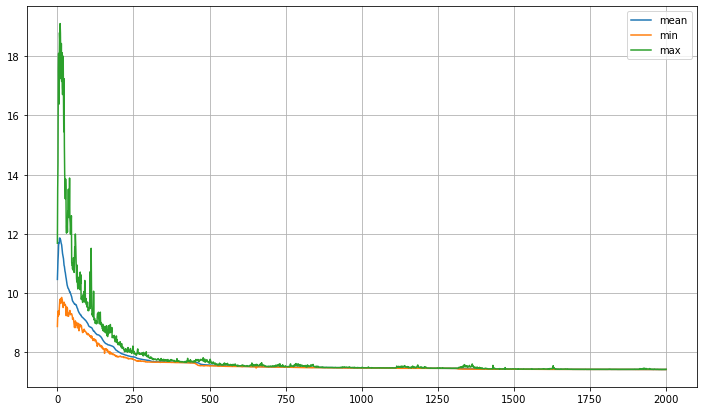

In [42]:
l = 50
t = 1/np.sqrt(2*l)
t0 = 1/np.sqrt(2*np.sqrt(l))

populations, scores = ES(F=Ackley, c_len=l, population_size=1000, offspring_size=1000, tau=t, tau0=t0, iterations=2000, min_bound=-32, max_bound=32, plus=False)

plot_min_max_mean(scores)

100%|██████████| 200/200 [00:01<00:00, 171.08it/s]


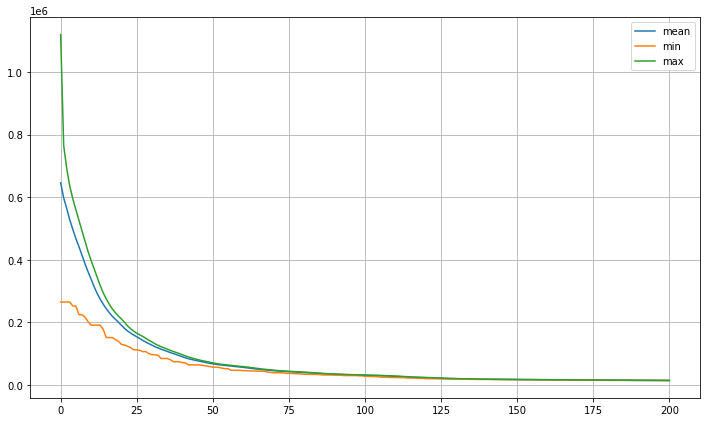

In [8]:
l = 50
t = 1/np.sqrt(2*l)
t0 = 1/np.sqrt(2*np.sqrt(l))

populations, scores = ES(F=Dixon_Price, c_len=l, population_size=1000, offspring_size=500, tau=t, tau0=t0, iterations=200)

plot_min_max_mean(scores)

100%|██████████| 200/200 [00:10<00:00, 18.36it/s]


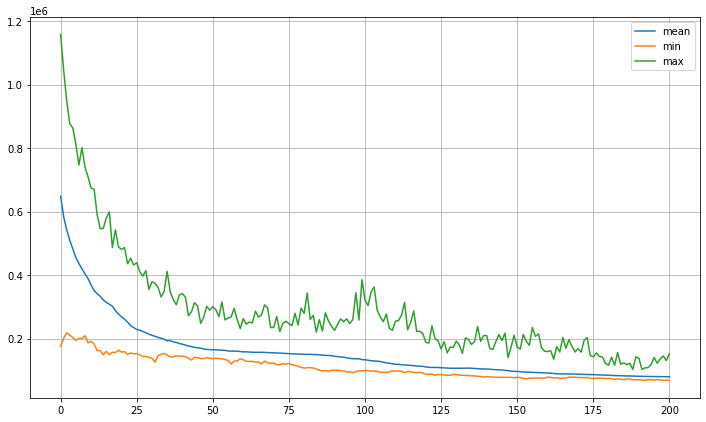

In [100]:
l = 50
t = 1/np.sqrt(2*l)
t0 = 1/np.sqrt(2*np.sqrt(l))

populations, scores = ES(F=Dixon_Price, c_len=l, population_size=1000, offspring_size=1000, tau=t, tau0=t0, iterations=200, plus=False)


# scores
plot_min_max_mean(scores)

100%|██████████| 1000/1000 [00:33<00:00, 29.71it/s]


(array([-1.93253675e-01, -2.20539452e+01,  4.19645118e+00, -6.96271703e-01,
        5.67377881e-01, -1.04175603e+00, -1.05459391e+00,  3.93590789e-01,
        1.70863646e+00, -2.41074641e-01, -5.07438221e-02, -8.52300799e-02,
        4.23434321e-01,  3.69576232e+00, -3.01479845e-01,  1.17817004e-02,
        9.59288835e+00, -1.58723135e-01, -1.80624554e+00,  4.11075286e-02,
       -6.82313986e-01,  5.84264992e-01, -2.86019369e+00,  1.10754248e+00,
       -1.40209651e+00, -1.35265271e+00, -6.35577228e-02, -2.94511731e+00,
        5.12654179e-01,  1.56956342e+00, -1.57152491e-01, -6.57981910e-01,
       -1.04022114e+00,  1.53553577e+00,  1.74054599e-01, -9.98488541e+01,
       -8.64912602e+00, -8.04289120e-01,  5.94990197e-01,  2.60828626e-01,
       -5.32342155e-02, -6.66277015e-01, -1.70414972e-01, -1.51887242e-01,
        2.21528821e-01,  3.98750342e+00, -7.49793882e-01,  3.67532866e-01,
        3.09178205e-01, -1.47445350e-01]), 3.671547468032424)


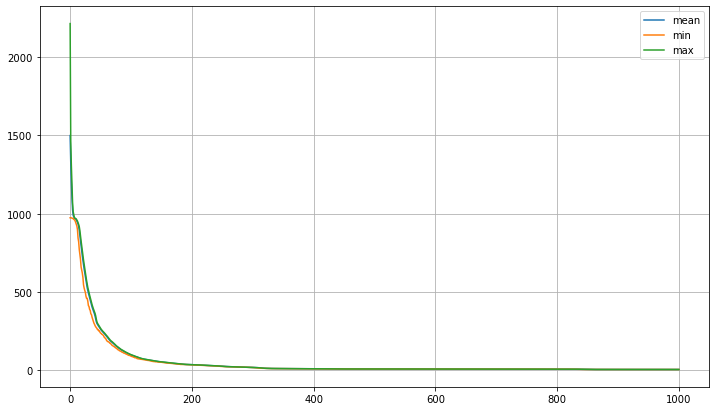

In [92]:
l = 50
t = 1/np.sqrt(2*l)
t0 = 1/np.sqrt(2*np.sqrt(l))

populations, scores = ES(F=Griewank, c_len=l, population_size=1000, offspring_size=1000, tau=t, tau0=t0, iterations=1000, min_bound=-600, max_bound=600)


print(best_individual(populations, scores))
plot_min_max_mean(scores)

100%|██████████| 250/250 [00:11<00:00, 21.57it/s]


(array([-1.78420127e+00,  2.90313005e-02, -6.88247858e-01,  4.30339652e-02,
       -9.33332701e-01,  1.71881541e+00, -2.48661943e-01, -1.24994584e+00,
       -8.44140036e-01,  2.27571202e-01,  5.73655308e-01,  3.74027523e-01,
        1.16596907e+00,  6.68668325e-01,  3.26327735e-01,  1.14566318e+00,
        1.93367327e+00, -1.04440073e+00,  6.84122114e-01, -2.23562814e+00,
        2.66304568e+00,  1.77247671e+00,  3.00004983e-01,  1.56361508e+00,
        1.45958222e+00,  1.83379978e+00,  6.69197546e-01,  1.39444870e+00,
        1.15423027e+00,  1.77386701e+00,  1.84597933e+00,  3.38039642e+00,
       -1.60241500e-02, -8.08821308e-02, -8.72567740e-01,  7.64812860e-01,
       -4.23923173e-03, -1.06906255e+00,  6.36206067e-01,  3.62318839e-01,
       -3.33191880e-01,  1.17318562e+00, -4.33109324e-01,  4.48046606e-02,
        5.89380663e-01, -3.52236636e+00,  1.52790672e+00,  6.84645016e-01,
       -3.34514774e+00,  8.77094791e+00]), 41542.747749875256)


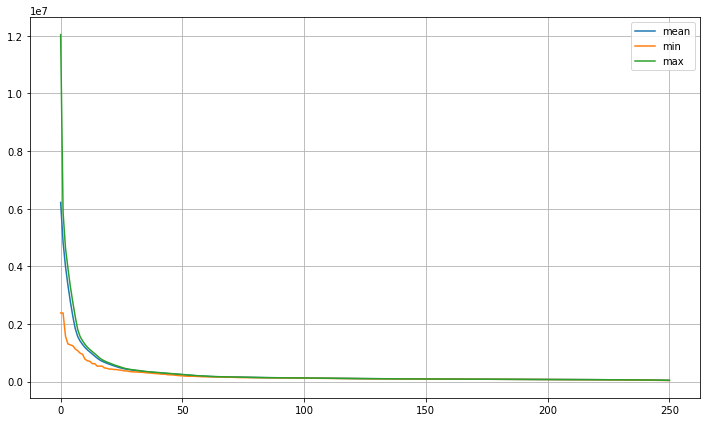

In [93]:
l = 50
t = 1/np.sqrt(2*l)
t0 = 1/np.sqrt(2*np.sqrt(l))

populations, scores = ES(F=Rosenbrock, c_len=l, population_size=1000, offspring_size=1000, tau=t, tau0=t0, iterations=250, min_bound=-5, max_bound=10)

print(best_individual(populations, scores))
plot_min_max_mean(scores)

100%|██████████| 1000/1000 [00:30<00:00, 32.26it/s]


(array([ 421.55973663, -125.05586928,  420.93470894, -195.41543718,
        421.12511257,  -26.06304865, -125.08067701,  421.09117875,
       -125.68838313, -124.40035722,   65.88159535,  202.69286787,
        204.00509919,  420.9963643 ,  420.81508036,  203.67435165,
       -124.77083637,  422.57901719,  204.04425259,  421.01224744,
       -302.51537758,  420.67387405, -124.87578754, -299.98387047,
        421.16441354,  420.93665914, -487.72026781, -302.37083587,
       -124.31309769,   65.71641857,  421.60240722,   65.7545738 ,
       -303.17726794,  420.10602435,  421.19757953,  420.93576681,
       -302.05057062,  203.13519843, -302.6141101 ,  204.6853545 ,
       -126.18458366,  423.80206715,  420.03398797, -302.89769529,
       -301.87553195, -372.19660924, -302.49315278,  206.88390646,
        201.00899979,  421.16776048]), 8202.484969269048)


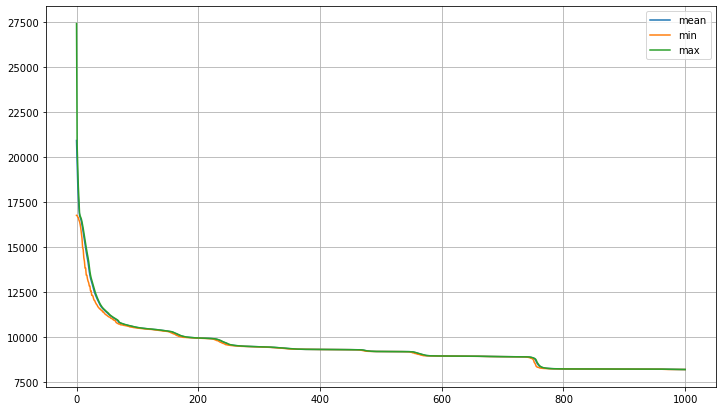

In [94]:
l = 50
t = 1/np.sqrt(2*l)
t0 = 1/np.sqrt(2*np.sqrt(l))

populations, scores = ES(F=Schwefel, c_len=l, population_size=1000, offspring_size=1000, tau=t, tau0=t0, min_bound=-500, max_bound=500, iterations=1000)

print(best_individual(populations, scores))
plot_min_max_mean(scores)